In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

100% 65.0M/65.2M [00:00<00:00, 162MB/s]
100% 65.2M/65.2M [00:00<00:00, 159MB/s]


In [ ]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Lambda, Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.applications import Xception
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

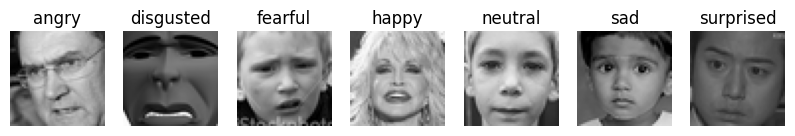

In [ ]:
index = 1
plt.figure(figsize=(10, 5))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir)[:1]:
        image = cv.imread(os.path.join(class_dir, filename))
        
        plt.subplot(1, len(classes), index)
        plt.title(classname)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        
        index += 1
        
plt.show()

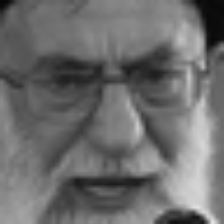

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)
        
    total_image_per_class.append(len(os.listdir(class_dir)))
        
data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
xception = Xception(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)
xception_model = xception.output
xception_model = Flatten(name="flatten")(xception_model)
xception_model = Dense(512, activation="relu")(xception_model)
xception_model = Dropout(0.5)(xception_model)
xception_model = Dense(7, activation="softmax")(xception_model)
model = Model(inputs=xception.input, outputs=xception_model)
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
for layer in xception.layers:
	layer.trainable = False

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 376s 498ms/step - loss: 1.5770 - accuracy: 0.3905 - val_loss: 1.4506 - val_accuracy: 0.4633
Epoch 2/20
718/718 [==============================] - 349s 485ms/step - loss: 1.4482 - accuracy: 0.4436 - val_loss: 1.3896 - val_accuracy: 0.4813
Epoch 3/20
718/718 [==============================] - 349s 486ms/step - loss: 1.3968 - accuracy: 0.4751 - val_loss: 1.3490 - val_accuracy: 0.4926
Epoch 4/20
718/718 [==============================] - 355s 494ms/step - loss: 1.3619 - accuracy: 0.4839 - val_loss: 1.3397 - val_accuracy: 0.5011
Epoch 5/20
718/718 [==============================] - 349s 486ms/step - loss: 1.3362 - accuracy: 0.4981 - val_loss: 1.3266 - val_accuracy: 0.5037
Epoch 6/20
718/718 [==============================] - 352s 491ms/step - loss: 1.3131 - accuracy: 0.5064 - val_loss: 1.3127 - val_accuracy: 0.5081
Epoch 7/20
718/718 [==============================] - 364s 507ms/step - loss: 1.2962 - accuracy: 0.5147 - val_loss: 1.2950 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

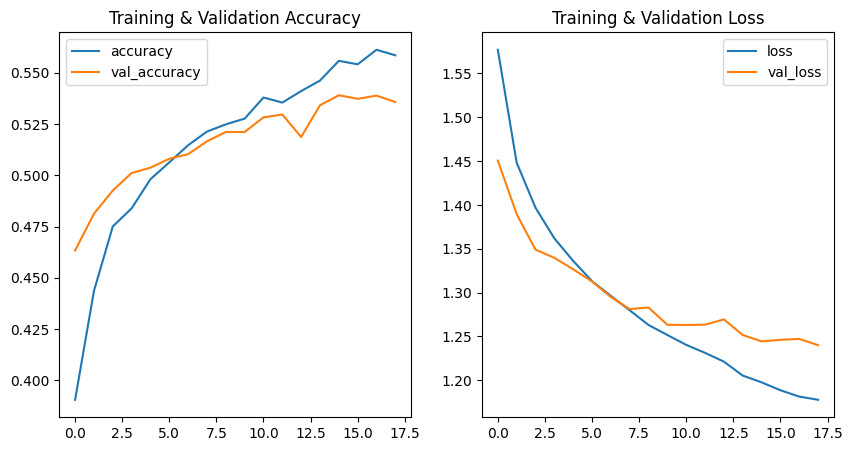

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 88s 389ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43       958
           1       1.00      0.04      0.07       111
           2       0.46      0.22      0.30      1024
           3       0.68      0.80      0.74      1774
           4       0.50      0.54      0.52      1233
           5       0.41      0.53      0.46      1247
           6       0.70      0.61      0.65       831

    accuracy                           0.54      7178
   macro avg       0.60      0.45      0.45      7178
weighted avg       0.55      0.54      0.53      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.5423516299804959
recall:  0.5423516299804959
precision:  0.5463948707320061
f1-score:  0.5281833573973064
Result =  0.539820372022576


In [ ]:
for layer in xception.layers:
	layer.trainable = True

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 474s 648ms/step - loss: 1.6221 - accuracy: 0.3653 - val_loss: 1.4656 - val_accuracy: 0.4384
Epoch 2/20
718/718 [==============================] - 481s 669ms/step - loss: 1.4520 - accuracy: 0.4441 - val_loss: 1.3790 - val_accuracy: 0.4694
Epoch 3/20
718/718 [==============================] - 477s 665ms/step - loss: 1.3740 - accuracy: 0.4766 - val_loss: 1.3188 - val_accuracy: 0.4994
Epoch 4/20
718/718 [==============================] - 467s 650ms/step - loss: 1.3180 - accuracy: 0.5006 - val_loss: 1.2745 - val_accuracy: 0.5145
Epoch 5/20
718/718 [==============================] - 488s 679ms/step - loss: 1.2705 - accuracy: 0.5196 - val_loss: 1.2388 - val_accuracy: 0.5222
Epoch 6/20
718/718 [==============================] - 460s 641ms/step - loss: 1.2304 - accuracy: 0.5379 - val_loss: 1.2169 - val_accuracy: 0.5374
Epoch 7/20
718/718 [==============================] - 478s 665ms/step - loss: 1.1906 - accuracy: 0.5452 - val_loss: 1.1988 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

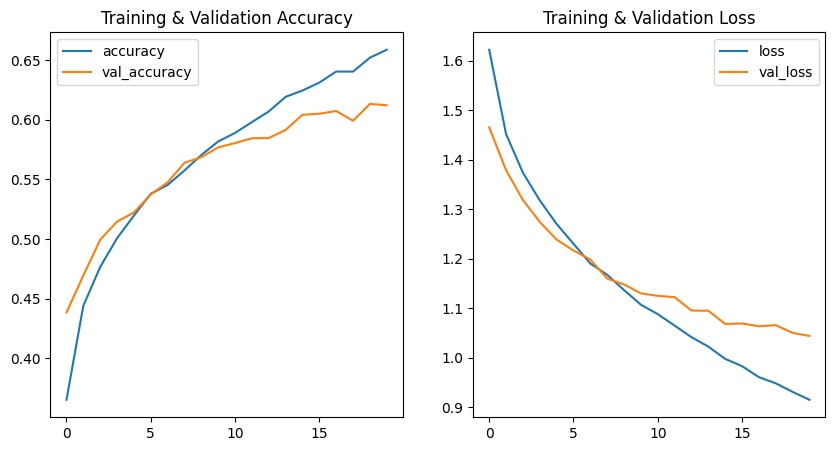

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 90s 398ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       958
           1       0.63      0.17      0.27       111
           2       0.47      0.38      0.42      1024
           3       0.82      0.84      0.83      1774
           4       0.59      0.57      0.58      1233
           5       0.45      0.54      0.49      1247
           6       0.72      0.79      0.75       831

    accuracy                           0.61      7178
   macro avg       0.60      0.54      0.55      7178
weighted avg       0.61      0.61      0.61      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.6139593201448872
recall:  0.6139593201448872
precision:  0.6131327802318981
f1-score:  0.6098587946017128
Result =  0.6127275537808463
